### 线性回归

#### 1. 线性模型
- 给定n维输入$\mathbf{x} = [x_1,x_2, \cdots, x_n]^T$
- 线性模型有一个n维权重$W$和一个标量偏差$b$
$$\mathbf{w} = [w_1,w_2, \cdots, w_n]^T, \quad b$$
- 输出是输入的加权和
$$y = w_1x_1 + w_2x_2 + \cdots + w_nx_n + b$$
- 向量版本的表达式
$$y = \langle \mathbf{w}, \mathbf{x} \rangle + b$$

#### 2. 衡量预估质量
- 比较真实值和预估值，例如房价的售价和预估价格
- 假设$y是真实值， \hat{y}是估计值， 我们可以比较$
$$l(y,\hat{y}) = \frac{1}{2}(y - \hat{y})^2$$

#### 3. 训练数据
- 假设有n个样本
$$\mathbf{X} = [\mathbf{x}_1, \mathbf{x}_2, \cdots, \mathbf{x}_n]^T \quad y = [y_1,y_2\cdots,y_n]^T$$

#### 4. 参数学习
- 训练损失
$$l(\mathbf{X}, \mathbf{y},\mathbf{w},b) = \frac{1}{2n}\sum_{i=1}^{n}{(y_i-\langle\mathbf{x_i}, \mathbf{w} \rangle - b)^2} = \frac{1}{2n}\|\mathbf{y} - \mathbf{Xw} - b\|_2$$
- 最小化损失函数来学习参数
$$\mathbf{w^*}, \mathbf{b^*} = \arg\min_{\mathbf{w},b}\ l(\mathbf{X},\mathbf{y},\mathbf{w},b)$$

#### 5. 具有显示解（也是这门课唯一一个具有显示解的模型）
<img src='images/8_image_1.png'>

### 基础优化方法

#### 1. 梯度下降
$$\mathbf{w}_t = \mathbf{w}_{t-1} - \eta\frac{\partial l}{\partial \mathbf{w}}$$
- $\eta$:学习率，是一个超参数
- **超参数**：人为指定的参数，不是通过学习得到的


<img src="images/8_image_2.png" height='200'>


#### 2. 小批量随机梯度下降
- 梯度的计算复杂度与样本的个数是线性相关的
- 在整个训练集上面计算一次梯度太贵，时间太长
- 每一个样本就计算一次梯度可能计算出来的数值又不太准确
- 所以我们可以随即采取 **b个样本**来近似损失
$$\frac{1}{b}\sum_{i\in I_b}{l(\mathbf{x}_i,y_i,\mathbf{w})}$$
- b是一个批次大小，也是一个人为指定的超参数

### 线性回归从0开始实现
从0开始实现整个方法，包括数据流水线，模型，损失函数和小批量随机梯度下降

In [48]:
# 嵌入到单元格
%matplotlib inline  
import random
import torch
from d2l import torch as d2l

- 这里不使用某一个特定的数据集，而是进行数据集的构造，为了便于可视化，构造一个二维的数据集
- 使用一个已知参数的线性模型去生成数据集，加上噪声，然后去训练来拟合这个噪声
- 这里选用$\mathbf{w} = [2, -3.4]^T,b = 4.2$的线性模型以及噪声项$\epsilon$
$$y = \mathbf{Xw} + b + \epsilon$$

In [49]:
def synthetic_data(w, b, num_examples):
    # 生成均值为0， 标准差为1， 大小为num_examples * len(w)的随机数
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y

true_w = torch.tensor([2, -3.4])
true_b = 4.2
num_examples = 1000
features, labels = synthetic_data(true_w, true_b, num_examples)

- features就是一个样本表，labels就是目标值

In [50]:
print(f"features:{features[0]}, \n labels:{labels[0]}")

features:tensor([0.6774, 0.3331]), 
 labels:4.418905735015869


- 对第二个特征和labels进行可视化

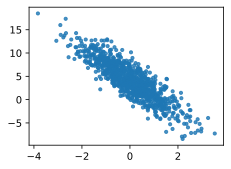

In [51]:
import matplotlib.pyplot as plt

plt.scatter(features[:, 1], labels, alpha=0.8, s=[10])

- 读取数据集
- 下方定义一个函数，用于接收数据集，并且返回batch_size大小的数据出来
- **笔记：**
  - **yield**，python中的关键字
  - 暂停函数执行并将值返回给调用者的方式
  - 使用 yield 的函数不会立即返回一个值，而是返回一个**生成器对象**。生成器对象可以按需返回多个值，每次返回一个值，直到没有更多的值为止。
  - yield与return不同，yield只是暂停函数，但是return执行之后会把函数的所有东西都清除

In [52]:
def yiled_test(max:int):
    count = 0
    while count < max:
        yield count
        count += 1

a = yiled_test(5)
print(a)
for i in a:
    print(i)


<generator object yiled_test at 0x0000012BE0A51C10>
0
1
2
3
4


In [53]:
import random

def data_iter(batch_size, featrues, labels):
    # 获取样本长度
    num_examples = len(labels)
    # 获取样本下标
    indices = list(range(num_examples))
    # 打乱样本，实现随机抽取
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = indices[i:min(i + batch_size, num_examples)]
        yield featrues[batch_indices], labels[batch_indices]

- 打印一下第一个batch验证函数写的是否正确

In [54]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.6908, -1.0123],
        [ 0.1243,  0.9196],
        [-0.8121,  0.1159],
        [-0.6612, -0.7221],
        [ 1.6130, -0.0947],
        [ 1.6160, -0.2556],
        [-0.6592,  1.2299],
        [-0.6525,  0.3620],
        [ 0.5284,  1.4523],
        [ 0.0153, -0.5542]]) 
 tensor([ 6.2602,  1.3210,  2.2013,  5.3097,  7.7515,  8.3184, -1.3060,  1.6639,
         0.3129,  6.1303])


- 初始化模型参数

In [63]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

- 定义模型

In [56]:
def linreg(X, w, b):
    return torch.matmul(X, w) + b

- 定义损失函数

In [57]:
def squared_loss(y_hat, y):
    return (y - y_hat.reshape(y.shape)) ** 2 / 2

- 定义优化器函数

In [58]:
def sgd(params:list[torch.Tensor], lr, batch_size: int):
    '''小批量随机梯度下降'''
    with torch.no_grad():
        for param in params:
            param -= param.grad * lr / batch_size
            param.grad.zero_()

- 模型训练

epoch:1's loss = :0.03716586157679558
epoch:2's loss = :0.00012769461318384856
epoch:3's loss = :4.691009962698445e-05
epoch:4's loss = :4.67954741907306e-05
epoch:5's loss = :4.675467062043026e-05


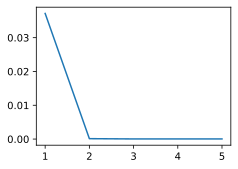

In [64]:
import matplotlib.pyplot as plt
num_epochs = 5
batch_size = 10
lr = 0.03
net = linreg
loss = squared_loss
losses = []

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        y_hat = net(X, w, b)
        # 这里返回的是一个10 * 1 的向量
        l = loss(y_hat, y)
        l.sum().backward()
        sgd([w, b], lr, batch_size)

    with torch.no_grad():
        train_loss = loss(net(features, w, b), labels)
        losses.append(train_loss.mean())
        print(f"epoch:{epoch + 1}'s loss = :{train_loss.mean()}")

plt.plot(list(range(1, num_epochs + 1)), losses)


- batch_size过小不会影响最终的结果，因为对于深度神经网络来说，网络太复杂了，很容易出现过拟合，batch越小那么你一次梯度下降里面的噪音就越多，就比如训练集中有100万张图片，但是一个batch只有2，那么噪音就很大，在深度神经网络中，一定的噪音可以防止网络过拟合，有很好的训练效果

### 线性回归简洁实现
- 生成数据集

In [65]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l        
true_w = torch.normal(0, 0.01, (2, 1))
true_b = torch.zeros(1)

- 加载数据集

In [66]:
def load_array(X, y, batch_size, is_train=True):
    dataset = data.TensorDataset(X, y)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array(features, labels, batch_size)

- 定义模型

In [74]:
from torch import nn

net = nn.Sequential(nn.Linear(in_features=2, out_features=1))


- 初始化模型参数

In [89]:
net[0].weight.data.normal_(0, 10)
net[0].bias.data.fill_(100)

tensor([100.])

- 定义损失函数

In [76]:
loss = nn.MSELoss()

- 定义优化算法

In [77]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

- 模型训练

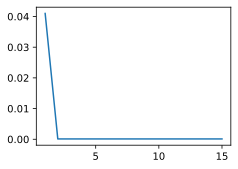

In [90]:
num_epochs = 15
losses = []
for epoch in range(num_epochs):
    for X, y in data_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        # 梯度清零
        trainer.zero_grad()
        # 反向求导
        l.backward()
        # 随机梯度下降优化
        trainer.step()
    l = loss(net(features), labels)
    losses.append(l.detach().to('cpu').numpy())
    # print(f"epoch:{epoch + 1}'s loss :{l}")

plt.plot(list(range(1, num_epochs + 1)), losses)
